In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_customers = pd.read_parquet("../data/raw/customer_profile.parquet")
df_loans = pd.read_parquet("../data/raw/loan_master.parquet")
df_repayment = pd.read_parquet("../data/raw/repayment.parquet")
df_transactions = pd.read_parquet("../data/raw/transaction.parquet")

In [3]:
dfs = {
    "customers": df_customers,
    "loans": df_loans,
    "repayment": df_repayment,
    "transactions": df_transactions
}

In [4]:
# basic Stats check

for name, df in dfs.items():
    print(f"==={name.upper()}===")
    print(df.head(3))
    print(df.columns)
    print(df.info())
    print(df.shape)
    print(df.describe(include="all").T)
    print("="*80)

===CUSTOMERS===
  account_id  age  income  gender employment_type  prior_loans_count  \
0   ACC00001   59   54782    male   self_employed                  1   
1   ACC00002   49   98533    male        salaried                  1   
2   ACC00003   35   92684  female   self_employed                  0   

   credit_score  
0           545  
1           671  
2           689  
Index(['account_id', 'age', 'income', 'gender', 'employment_type',
       'prior_loans_count', 'credit_score'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   account_id         5000 non-null   object
 1   age                5000 non-null   int32 
 2   income             5000 non-null   int32 
 3   gender             5000 non-null   object
 4   employment_type    5000 non-null   object
 5   prior_loans_count  5000 non-null   int32 
 6   cr

In [5]:
# missing value and uniqueness of primary key

for name, df in dfs.items():
    print(f"=== {name.upper()} missing values ===")
    print(df.isna().mean().sort_values(ascending=False))  # fraction of missing
    print()

# Primary key uniqueness
print("customer account_id unique:", df_customers["account_id"].is_unique)
print("loans loan_id unique:", df_loans["loan_id"].is_unique)
print("transactions txn_id unique:", df_transactions["txn_id"].is_unique)

# Duplicates check
for name, df in dfs.items():
    print(f"{name} duplicates:", df.duplicated().sum())


=== CUSTOMERS missing values ===
account_id           0.0
age                  0.0
income               0.0
gender               0.0
employment_type      0.0
prior_loans_count    0.0
credit_score         0.0
dtype: float64

=== LOANS missing values ===
loan_id              0.0
account_id           0.0
disbursement_date    0.0
loan_amount          0.0
tenure_months        0.0
interest_rate        0.0
emi_amount           0.0
loan_type            0.0
dtype: float64

=== REPAYMENT missing values ===
actual_payment_date     0.403405
loan_id                 0.000000
installment_no          0.000000
account_id              0.000000
due_date                0.000000
payment_amount          0.000000
dpd                     0.000000
partial_payment_flag    0.000000
dtype: float64

=== TRANSACTIONS missing values ===
txn_id            0.0
account_id        0.0
txn_timestamp     0.0
txn_type          0.0
amount            0.0
balance_before    0.0
balance_after     0.0
salary_flag       0.0
dtype:

In [6]:
"""
data integrity

account_id in loans/repayment/transactions must exist in customer

"""
print("Missing account_ids in customer (from loans):",
      (~df_loans["account_id"].isin(df_customers["account_id"])).sum())
print("Missing account_ids in customer (from repayment):",
      (~df_repayment["account_id"].isin(df_customers["account_id"])).sum())
print("Missing account_ids in customer (from transactions):",
      (~df_transactions["account_id"].isin(df_customers["account_id"])).sum())

# loan_id in repayment must exist in loans

print("Missing loan_ids in loans (from repayment):",
      (~df_repayment["loan_id"].isin(df_loans["loan_id"])).sum())

Missing account_ids in customer (from loans): 0
Missing account_ids in customer (from repayment): 0
Missing account_ids in customer (from transactions): 0
Missing loan_ids in loans (from repayment): 0


In [7]:
"""
Datetime conversion with date sanity check
"""

date_cols_loans = ["disbursement_date"]
date_cols_repay = ["due_date", "actual_payment_date"]
date_cols_txn   = ["txn_timestamp"]

for col in date_cols_loans:
    df_loans[col] = pd.to_datetime(df_loans[col])

for col in date_cols_repay:
    df_repayment[col] = pd.to_datetime(df_repayment[col], errors="coerce")

for col in date_cols_txn:
    df_transactions[col] = pd.to_datetime(df_transactions[col])

# Sanity: due_date >= disbursement_date
repayment_merged_tmp = df_repayment.merge(
    df_loans[["loan_id", "disbursement_date"]],
    on="loan_id", how="left"
)

invalid_due = (repayment_merged_tmp["due_date"] < repayment_merged_tmp["disbursement_date"]).sum()
print("Repayment rows with due_date before disbursement_date:", invalid_due)


Repayment rows with due_date before disbursement_date: 0


In [8]:
"""
Repayment aggreagation by loan_id
"""

repay_agg = (
    df_repayment
    .groupby("loan_id")
    .agg(
        max_dpd=("dpd", "max"),
        mean_dpd=("dpd", "mean"),
        num_instalments=("installment_no", "nunique"),
        num_partial_payments=("partial_payment_flag", lambda x: (x == 1).sum()),
        total_paid=("payment_amount", "sum"),
        first_due_date=("due_date", "min"),
        last_due_date=("due_date", "max"),
        first_actual_payment=("actual_payment_date", "min")
    )
    .reset_index()
)

repay_agg["is_default"] = (repay_agg["max_dpd"] > 90).astype(int)
repay_agg

,loan_id,max_dpd,mean_dpd,num_instalments,num_partial_payments,total_paid,first_due_date,last_due_date,first_actual_payment,is_default
0,LN000001,28,3.458333,24,0,3.955594e+05,2022-09-30,2024-08-30,2022-09-30,0
1,LN000002,15,1.333333,36,0,1.148478e+06,2023-12-15,2026-11-15,2023-12-15,0
2,LN000003,90,10.166667,12,1,4.897828e+05,2023-09-30,2024-08-30,2023-09-30,0
3,LN000004,999,374.625000,24,0,9.167493e+05,2023-08-10,2025-07-10,2023-08-10,1
4,LN000005,25,3.791667,24,1,9.933965e+05,2024-05-26,2026-04-26,2024-05-26,0
...,...,...,...,...,...,...,...,...,...,...
5995,LN005996,0,0.000000,12,0,1.703781e+06,2022-08-04,2023-07-04,2022-08-04,0
5996,LN005997,65,5.888889,36,2,2.379492e+06,2022-08-22,2025-07-22,2022-09-12,0
5997,LN005998,8,1.000000,12,0,1.722015e+06,2024-11-28,2025-10-28,2024-11-28,0
5998,LN005999,999,750.444444,36,1,6.380102e+04,2022-06-25,2025-05-25,2022-06-25,1


In [ ]:
#joining repay agg with loan table for payment ratio
repay_agg = repay_agg.merge(
    df_loans[["loan_id", "loan_amount", "emi_amount", "tenure_months"]],
    on="loan_id",
    how="left"
)

# Simple payment ratio – total paid vs loan amount
repay_agg["payment_ratio"] = (repay_agg["total_paid"] / repay_agg["loan_amount"])
repay_agg

,loan_id,max_dpd,mean_dpd,num_instalments,num_partial_payments,total_paid,first_due_date,last_due_date,first_actual_payment,is_default,loan_amount,emi_amount,tenure_months,payment_ratio
0,LN000001,28,3.458333,24,0,3.955594e+05,2022-09-30,2024-08-30,2022-09-30,0,314810,16481.64,24,1.256502
1,LN000002,15,1.333333,36,0,1.148478e+06,2023-12-15,2026-11-15,2023-12-15,0,904421,31902.16,36,1.269849
2,LN000003,90,10.166667,12,1,4.897828e+05,2023-09-30,2024-08-30,2023-09-30,0,440783,41202.48,12,1.111165
3,LN000004,999,374.625000,24,0,9.167493e+05,2023-08-10,2025-07-10,2023-08-10,1,1214831,61116.62,24,0.754631
4,LN000005,25,3.791667,24,1,9.933965e+05,2024-05-26,2026-04-26,2024-05-26,0,791032,41697.91,24,1.255823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,LN005996,0,0.000000,12,0,1.703781e+06,2022-08-04,2023-07-04,2022-08-04,0,1504683,141981.71,12,1.132319
5996,LN005997,65,5.888889,36,2,2.379492e+06,2022-08-22,2025-07-22,2022-09-12,0,1867382,67311.98,36,1.274240
5997,LN005998,8,1.000000,12,0,1.722015e+06,2024-11-28,2025-10-28,2024-11-28,0,1591105,143501.27,12,1.082276
5998,LN005999,999,750.444444,36,1,6.380102e+04,2022-06-25,2025-05-25,2022-06-25,1,188851,7217.44,36,0.337838


In [10]:
# Join loans with customer to create a loan base 
loan_cust = df_loans.merge(
    df_customers,
    on="account_id",
    how="left",
    suffixes=("_loan", "_cust")
)

# Add repayment behavior
loan_base = loan_cust.merge(
    repay_agg,
    on="loan_id",
    how="left"
)

loan_base.head()


,loan_id,account_id,disbursement_date,loan_amount_x,tenure_months_x,interest_rate,emi_amount_x,loan_type,age,income,...,num_partial_payments,total_paid,first_due_date,last_due_date,first_actual_payment,is_default,loan_amount_y,emi_amount_y,tenure_months_y,payment_ratio
0,LN000001,ACC04959,2022-08-30,314810,24,22.96,16481.64,personal,34,107897,...,0,3.955594e+05,2022-09-30,2024-08-30,2022-09-30,0,314810,16481.64,24,1.256502
1,LN000002,ACC00442,2023-11-15,904421,36,16.24,31902.16,personal,49,196819,...,0,1.148478e+06,2023-12-15,2026-11-15,2023-12-15,0,904421,31902.16,36,1.269849
2,LN000003,ACC02293,2023-08-30,440783,12,21.75,41202.48,vehicle,38,41058,...,1,4.897828e+05,2023-09-30,2024-08-30,2023-09-30,0,440783,41202.48,12,1.111165
3,LN000004,ACC01663,2023-07-10,1214831,24,18.79,61116.62,business,22,119301,...,0,9.167493e+05,2023-08-10,2025-07-10,2023-08-10,1,1214831,61116.62,24,0.754631
4,LN000005,ACC00871,2024-04-26,791032,24,23.68,41697.91,personal,55,57333,...,1,9.933965e+05,2024-05-26,2026-04-26,2024-05-26,0,791032,41697.91,24,1.255823


In [11]:
# 6 months (180 days) window before disbursement
transactions_txn = df_transactions.copy()

# join with disbursement_date
txn_with_loan_date = transactions_txn.merge(
    df_loans[["loan_id", "account_id", "disbursement_date"]],
    on="account_id",
    how="left"
)

# Filter to pre-loan window
mask_pre = (
    (txn_with_loan_date["txn_timestamp"] <= txn_with_loan_date["disbursement_date"]) &
    (txn_with_loan_date["txn_timestamp"] >= txn_with_loan_date["disbursement_date"] - pd.Timedelta(days=180))
)

txn_pre = txn_with_loan_date[mask_pre].copy()

txn_agg = (
    txn_pre
    .groupby("loan_id")
    .agg(
        pre_txn_count=("txn_id", "count"),
        pre_debit_sum=("amount", lambda x: x[txn_pre.loc[x.index, "txn_type"] == "debit"].sum()),
        pre_credit_sum=("amount", lambda x: x[txn_pre.loc[x.index, "txn_type"] == "credit"].sum()),
        pre_avg_balance=("balance_before", "mean"),
        salary_txn_months=("salary_flag", lambda x: (x == 1).sum())
    )
    .reset_index()
)

loan_base = loan_base.merge(txn_agg, on="loan_id", how="left")
loan_base.head()

,loan_id,account_id,disbursement_date,loan_amount_x,tenure_months_x,interest_rate,emi_amount_x,loan_type,age,income,...,is_default,loan_amount_y,emi_amount_y,tenure_months_y,payment_ratio,pre_txn_count,pre_debit_sum,pre_credit_sum,pre_avg_balance,salary_txn_months
0,LN000001,ACC04959,2022-08-30,314810,24,22.96,16481.64,personal,34,107897,...,0,314810,16481.64,24,1.256502,75.0,0.0,0.0,2.267589e+05,6.0
1,LN000002,ACC00442,2023-11-15,904421,36,16.24,31902.16,personal,49,196819,...,0,904421,31902.16,36,1.269849,226.0,0.0,0.0,9.663774e+06,25.0
2,LN000003,ACC02293,2023-08-30,440783,12,21.75,41202.48,vehicle,38,41058,...,0,440783,41202.48,12,1.111165,297.0,0.0,0.0,3.670722e+04,29.0
3,LN000004,ACC01663,2023-07-10,1214831,24,18.79,61116.62,business,22,119301,...,1,1214831,61116.62,24,0.754631,311.0,0.0,0.0,1.224116e+06,30.0
4,LN000005,ACC00871,2024-04-26,791032,24,23.68,41697.91,personal,55,57333,...,0,791032,41697.91,24,1.255823,123.0,0.0,0.0,6.058574e+04,13.0


In [14]:
def plot_num_dist(df, col, hue=None, bins=30):
    plt.figure(figsize=(6,4))
    if hue:
        sns.histplot(data=df, x=col, hue=hue, kde=True, bins=bins, element="step")
    else:
        sns.histplot(data=df, x=col, kde=True, bins=bins)
    plt.title(f"Distribution of {col}")
    plt.show()

def plot_cat_counts(df, col, hue=None, normalize=False):
    plt.figure(figsize=(6,4))
    if normalize:
        data = (df.groupby(col)[hue].value_counts(normalize=True)
                  .rename("frac").reset_index())
        sns.barplot(data=data, x=col, y="frac", hue=hue)
    else:
        sns.countplot(data=df, x=col, hue=hue)
    plt.title(f"{col} distribution")
    plt.xticks(rotation=45)
    plt.show()

In [18]:
loan_base.columns

Index(['loan_id', 'account_id', 'disbursement_date', 'loan_amount_x',
       'tenure_months_x', 'interest_rate', 'emi_amount_x', 'loan_type', 'age',
       'income', 'gender', 'employment_type', 'prior_loans_count',
       'credit_score', 'max_dpd', 'mean_dpd', 'num_instalments',
       'num_partial_payments', 'total_paid', 'first_due_date', 'last_due_date',
       'first_actual_payment', 'is_default', 'loan_amount_y', 'emi_amount_y',
       'tenure_months_y', 'payment_ratio', 'pre_txn_count', 'pre_debit_sum',
       'pre_credit_sum', 'pre_avg_balance', 'salary_txn_months'],
      dtype='object')

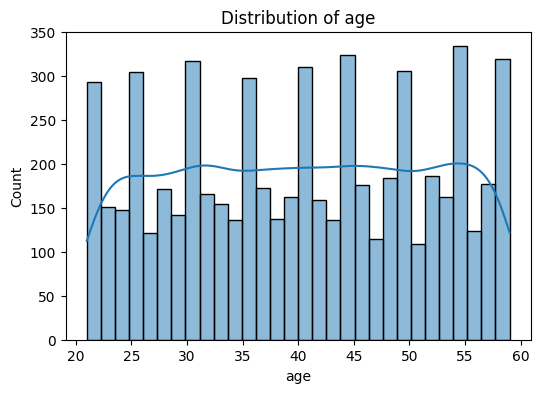

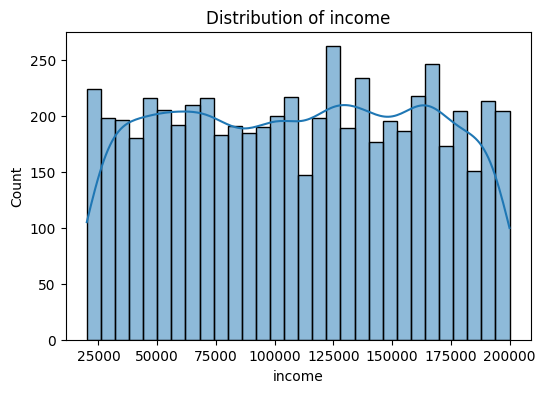

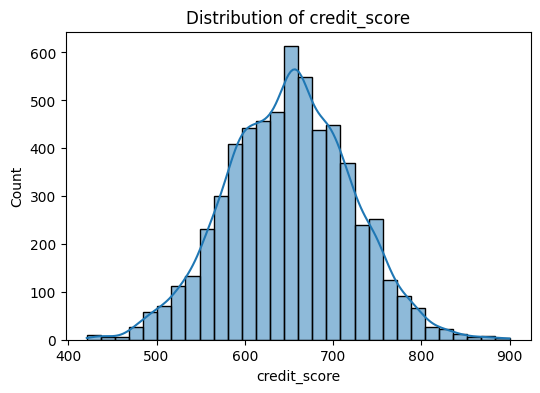

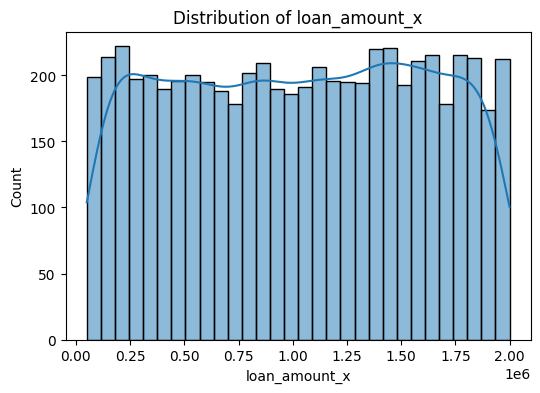

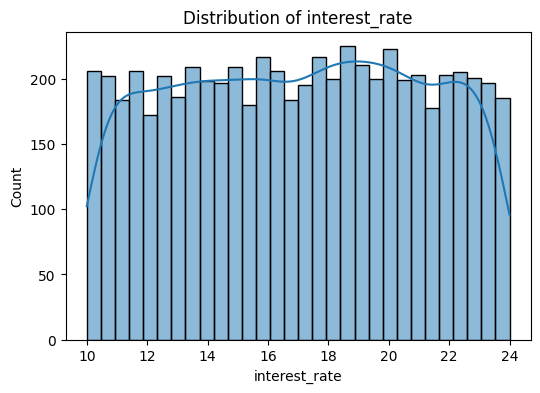

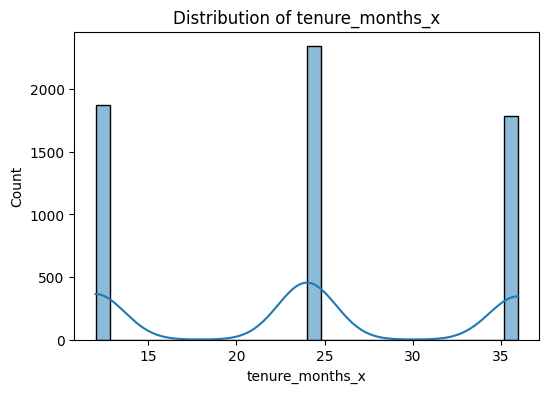

In [20]:
num_cols = ["age", "income", "credit_score", "loan_amount_x", "interest_rate", "tenure_months_x"]

for col in num_cols:
    plot_num_dist(loan_base, col)

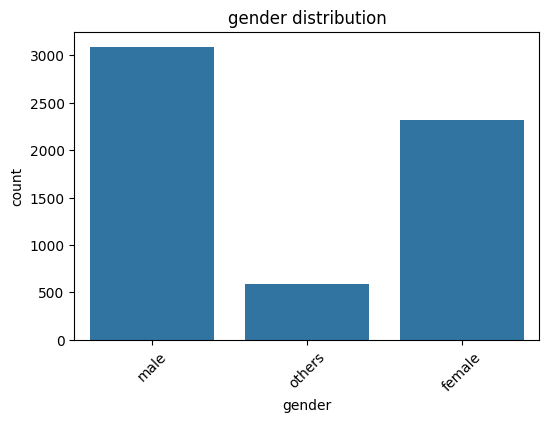

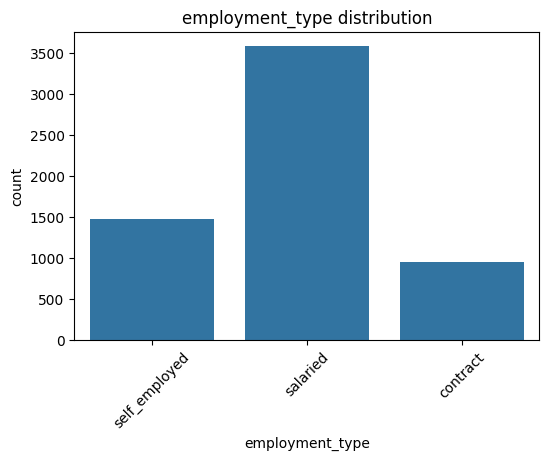

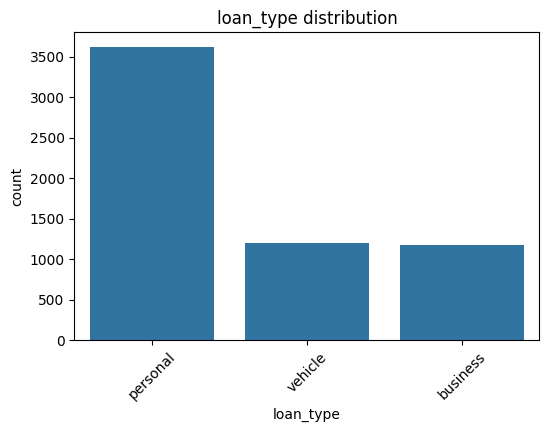

In [17]:
cat_cols = ["gender", "employment_type", "loan_type"]

for col in cat_cols:
    plot_cat_counts(loan_base, col)

,default_rate,n
gender,,
male,0.596639,3094
others,0.595563,586
female,0.587069,2320


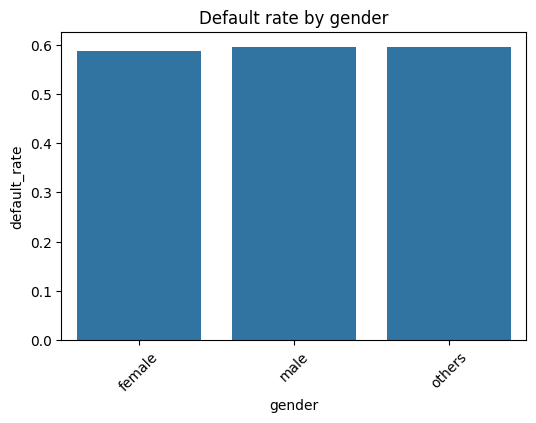

,default_rate,n
employment_type,,
contract,0.597895,950
salaried,0.595305,3578
self_employed,0.583560,1472


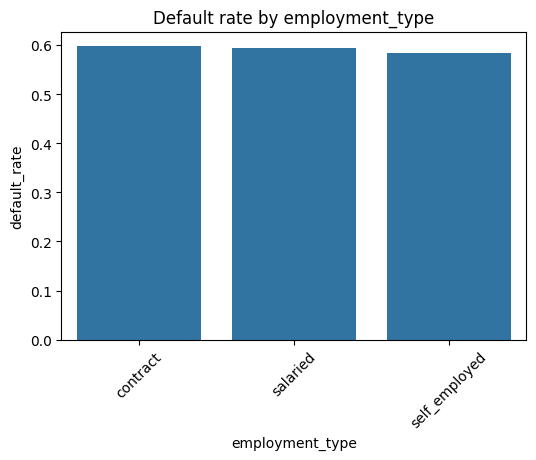

,default_rate,n
loan_type,,
vehicle,0.611343,1199
business,0.588285,1178
personal,0.588187,3623


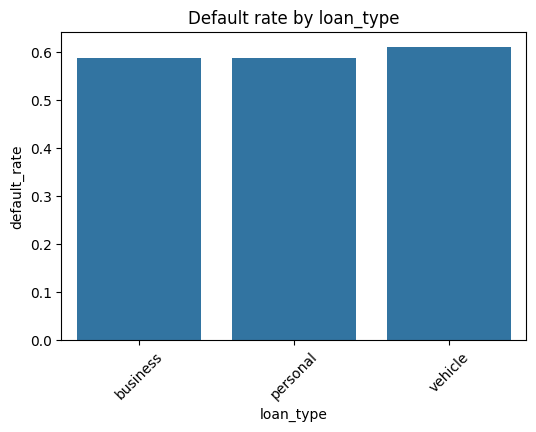

In [21]:
def default_rate_by_cat(df, col):
    grp = (df
           .groupby(col)["is_default"]
           .agg(["mean", "count"])
           .rename(columns={"mean": "default_rate", "count": "n"}))
    display(grp.sort_values("default_rate", ascending=False))

    plt.figure(figsize=(6,4))
    sns.barplot(x=grp.index, y="default_rate", data=grp.reset_index())
    plt.title(f"Default rate by {col}")
    plt.xticks(rotation=45)
    plt.show()

for col in cat_cols:
    default_rate_by_cat(loan_base, col)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_53392\3216719726.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_tmp.groupby(col + "_bin")["is_default"].agg(["mean", "count"])


,mean,count
income_bin,,
"(20027.999, 55183.4]",0.585833,1200
"(55183.4, 92227.0]",0.592839,1201
"(92227.0, 127821.2]",0.610509,1199
"(127821.2, 163672.8]",0.588333,1200
"(163672.8, 199965.0]",0.586667,1200


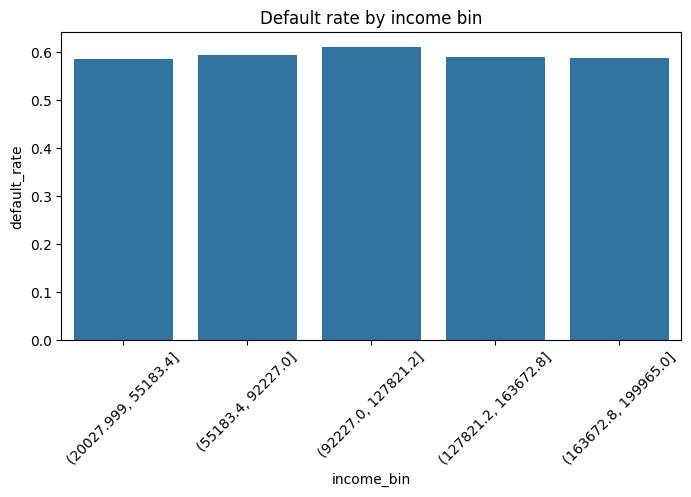

C:\Users\lenovo\AppData\Local\Temp\ipykernel_53392\3216719726.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_tmp.groupby(col + "_bin")["is_default"].agg(["mean", "count"])


,mean,count
loan_amount_x_bin,,
"(50544.999, 433906.0]",0.597500,1200
"(433906.0, 838088.0]",0.600000,1200
"(838088.0, 1231679.2]",0.590833,1200
"(1231679.2, 1611913.6]",0.580000,1200
"(1611913.6, 1999498.0]",0.595833,1200


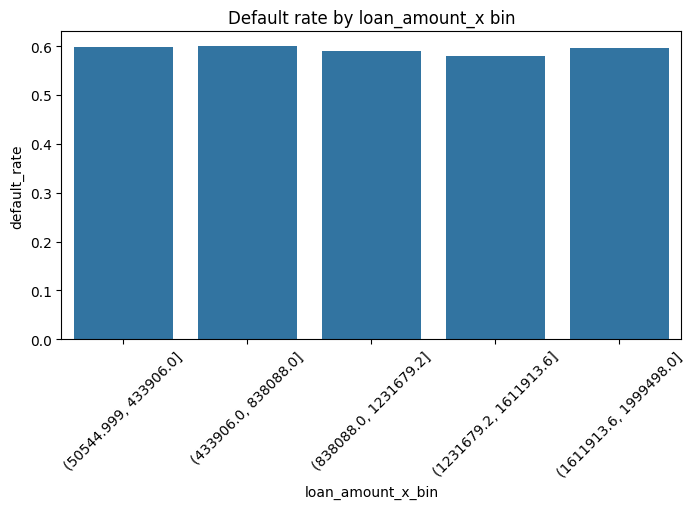

C:\Users\lenovo\AppData\Local\Temp\ipykernel_53392\3216719726.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_tmp.groupby(col + "_bin")["is_default"].agg(["mean", "count"])


,mean,count
credit_score_bin,,
"(420.999, 591.0]",0.593543,1208
"(591.0, 633.0]",0.600833,1200
"(633.0, 668.0]",0.581491,1221
"(668.0, 709.0]",0.581494,1178
"(709.0, 900.0]",0.606873,1193


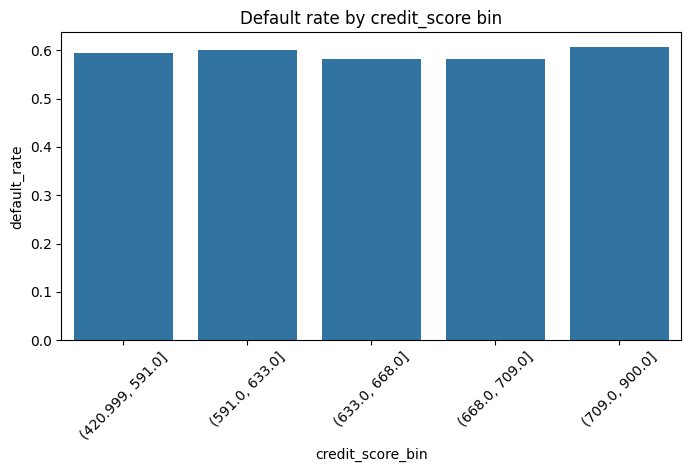

C:\Users\lenovo\AppData\Local\Temp\ipykernel_53392\3216719726.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_tmp.groupby(col + "_bin")["is_default"].agg(["mean", "count"])


,mean,count
interest_rate_bin,,
"(9.999, 12.86]",0.585691,1202
"(12.86, 15.68]",0.612823,1201
"(15.68, 18.464]",0.586466,1197
"(18.464, 21.11]",0.577019,1201
"(21.11, 24.0]",0.602168,1199


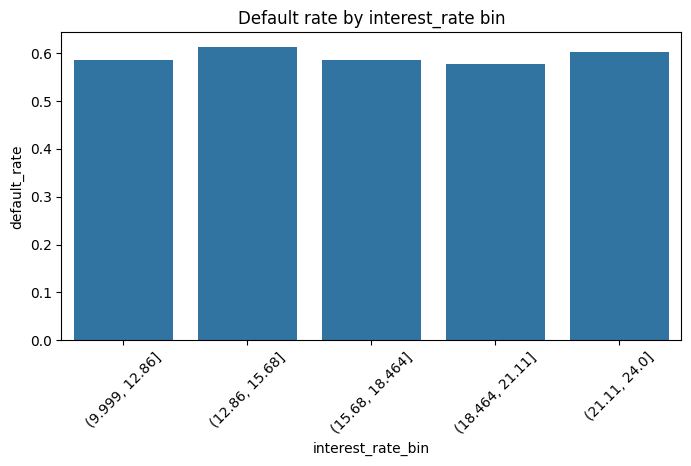

In [23]:
def default_rate_by_bin(df, col, q=5):
    df_tmp = df.copy()
    df_tmp[col + "_bin"] = pd.qcut(df_tmp[col], q=q, duplicates="drop")
    grp = df_tmp.groupby(col + "_bin")["is_default"].agg(["mean", "count"])
    display(grp)

    plt.figure(figsize=(8,4))
    sns.barplot(x=grp.index.astype(str), y="mean", data=grp.reset_index())
    plt.title(f"Default rate by {col} bin")
    plt.xticks(rotation=45)
    plt.ylabel("default_rate")
    plt.show()

for col in ["income", "loan_amount_x", "credit_score", "interest_rate"]:
    default_rate_by_bin(loan_base, col)


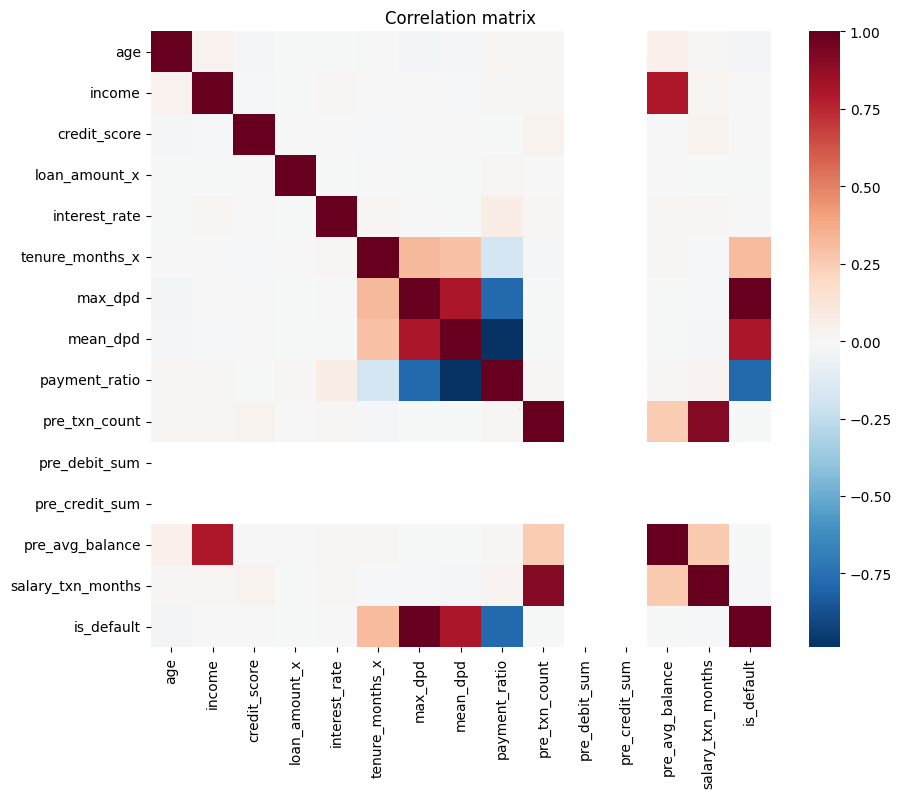

In [25]:
num_for_corr = [
    "age", "income", "credit_score",
    "loan_amount_x", "interest_rate", "tenure_months_x",
    "max_dpd", "mean_dpd", "payment_ratio",
    "pre_txn_count", "pre_debit_sum", "pre_credit_sum",
    "pre_avg_balance", "salary_txn_months",
    "is_default"
]

corr = loan_base[num_for_corr].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0)
plt.title("Correlation matrix")
plt.show()


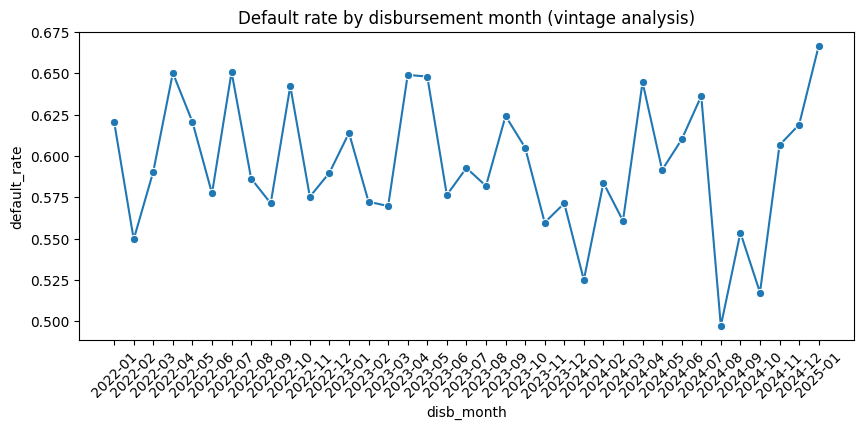

In [26]:
loan_base["disb_month"] = loan_base["disbursement_date"].dt.to_period("M")

vintage = (
    loan_base
    .groupby("disb_month")["is_default"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "default_rate"})
    .reset_index()
)

vintage["disb_month"] = vintage["disb_month"].astype(str)

plt.figure(figsize=(10,4))
sns.lineplot(data=vintage, x="disb_month", y="default_rate", marker="o")
plt.xticks(rotation=45)
plt.title("Default rate by disbursement month (vintage analysis)")
plt.show()


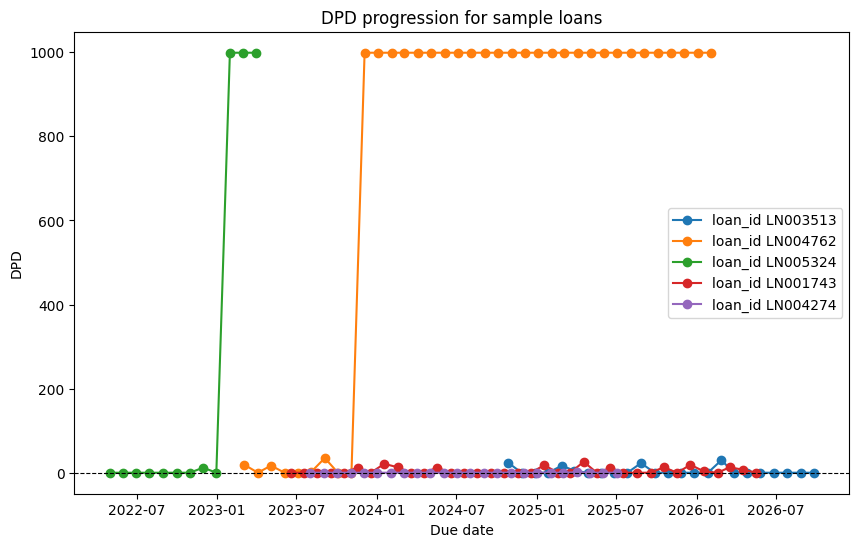

In [29]:
# Example: DPD trajectory for a sample of loans
sample_loans = np.random.choice(loan_base["loan_id"].unique(), size=5, replace=False)

plt.figure(figsize=(10,6))
for lid in sample_loans:
    sub = df_repayment[df_repayment["loan_id"] == lid].sort_values("due_date")
    plt.plot(sub["due_date"], sub["dpd"], marker="o", label=f"loan_id {lid}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.ylabel("DPD")
plt.xlabel("Due date")
plt.title("DPD progression for sample loans")
plt.legend()
plt.show()


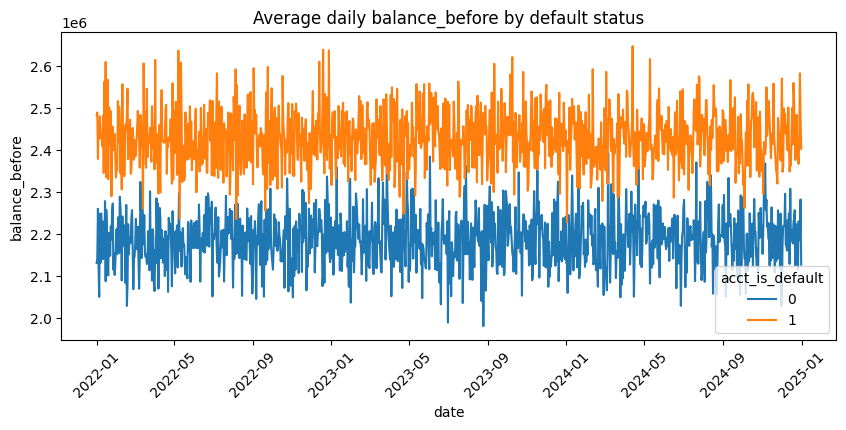

In [30]:
# Mark account-level default if any loan defaulted
account_default = (
    loan_base.groupby("account_id")["is_default"]
    .max()
    .reset_index()
    .rename(columns={"is_default": "acct_is_default"})
)

transactions_txn = df_transactions.merge(account_default, on="account_id", how="left")
transactions_txn["acct_is_default"] = transactions_txn["acct_is_default"].fillna(0).astype(int)

# Example: average daily balance_before by default vs non-default
transactions_txn["date"] = transactions_txn["txn_timestamp"].dt.date

daily_bal = (
    transactions_txn.groupby(["acct_is_default", "date"])["balance_before"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,4))
sns.lineplot(data=daily_bal, x="date", y="balance_before", hue="acct_is_default")
plt.title("Average daily balance_before by default status")
plt.xticks(rotation=45)
plt.show()

In [33]:
# Debt-to-income ratio
loan_base["dti"] = loan_base["loan_amount_x"] / (loan_base["income"] + 1e-6)

# EMI to income ratio
loan_base["emi_income_ratio"] = loan_base["emi_amount_x"] / (loan_base["income"] + 1e-6)

# Financial stability proxy
loan_base["net_cashflow_pre"] = loan_base["pre_credit_sum"] - loan_base["pre_debit_sum"]
loan_base["balance_volatility"] = (
    transactions_txn.groupby("account_id")["balance_before"]
    .transform(lambda x: x.std() / (x.mean() + 1e-6))
)

max_dpd              0.394902
mean_dpd             0.316965
payment_ratio        0.260289
tenure_months_x      0.017960
emi_income_ratio     0.002890
dti                  0.001440
interest_rate        0.001148
pre_avg_balance      0.000857
loan_amount_x        0.000851
income               0.000744
pre_txn_count        0.000557
salary_txn_months    0.000498
age                  0.000496
credit_score         0.000404
dtype: float64


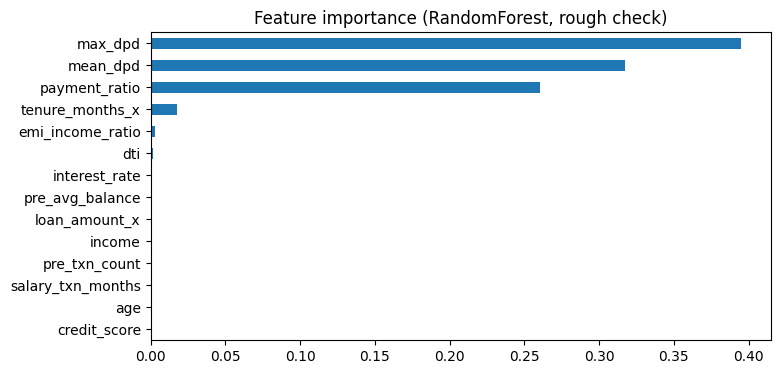

In [36]:
feature_cols = [
    "age", "income", "credit_score",
    "loan_amount_x", "interest_rate", "tenure_months_x",
    "payment_ratio", "max_dpd", "mean_dpd",
    "dti", "emi_income_ratio",
    "pre_txn_count", "pre_avg_balance", "salary_txn_months"
]

df_model = loan_base.dropna(subset=feature_cols + ["is_default"]).copy()

X = df_model[feature_cols]
y = df_model["is_default"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(imp)

plt.figure(figsize=(8,4))
imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature importance (RandomForest, rough check)")
plt.show()